### libraries

In [2]:
import os

from numba import cuda 

import pandas as pd
import numpy as np
from numpy import savetxt
from numpy import genfromtxt
from matplotlib import *
import matplotlib.pyplot as plt
import h5py
import math
import scipy
from scipy import ndimage
import sklearn
import seaborn as sns

import tensorflow as tf
from tensorflow import *
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import load_model

import keras
from keras.layers import Dense
from keras.models import Sequential
from keras.utils import to_categorical
from keras.callbacks import *

from sklearn.model_selection import train_test_split

%matplotlib inline

np.random.seed(1) # set a seed so that the results are consistent

### Classification using Keras

#### 1. Binary Classification

The goal is to distinguish between real and fake dollar bills. In order to do this, the dataset comes with 4 features: variance, skewness, kurtosis and entropy. These features are calculated by applying mathematical operations over the dollar bill images. The labels are found in the dataframe's class column.

,variace,skewness,curtosis,entropy,class
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


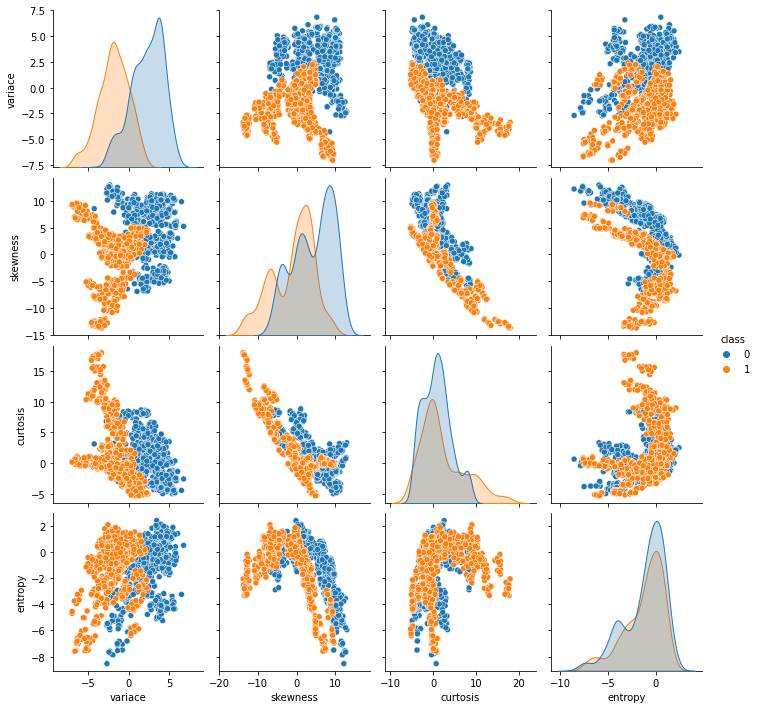

In [2]:
# data
bank_df = pd.read_csv('datasets/banknotes.csv')

sns.pairplot( data= bank_df, hue= 'class' )

bank_df.head()

You will perform binary classification by using a single neuron as an output. The input layer will have 4 neurons since we have 4 features in our dataset. The model's output will be a value constrained between 0 and 1.

We will interpret this output number as the probability of our input variables coming from a fake dollar bill, with 1 meaning we are certain it's a fake bill.


In [4]:
# data
bank_df

train_df = bank_df.sample(frac= 80./100)
test_df = bank_df.drop(train_df.index)

X_train = train_df.drop( 'class', axis= 1 ).to_numpy(dtype= 'float32')
Y_train = train_df['class'].to_numpy()

X_test = test_df.drop( 'class', axis= 1 ).to_numpy(dtype= 'float32')
Y_test = test_df['class'].to_numpy()

X_train.shape

# ---------------------------------------------------------------------------------------------------

# model architecture
tf.keras.backend.clear_session()
kSeqModel_1 = keras.Sequential()
kSeqModel_1.add(  layer= Dense( 4, activation= 'relu', input_shape= (X_train.shape[1],) )  )
kSeqModel_1.add(  layer= Dense( 1, activation= 'sigmoid' )  )

# model compile
kSeqModel_1.compile( optimizer= 'sgd', loss= 'binary_crossentropy', metrics= ['accuracy'] )

kSeqModel_1.summary()

# model fit
kSeqModel_1.fit( x= X_train, y= Y_train, epochs= 20, verbose= 2, validation_split= 20./100 )

# model accuracy
accuracy_model = kSeqModel_1.evaluate(x= X_test, y= Y_test)[1]

print('\n\nAccuracy : ', accuracy_model)

device = cuda.get_current_device()
device.reset()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
28/28 - 0s - loss: 0.9252 - accuracy: 0.5137 - val_loss: 0.8336 - val_accuracy: 0.5091
Epoch 2/20
28/28 - 0s - loss: 0.7318 - accuracy: 0.6071 - val_loss: 0.7039 - val_accuracy: 0.6136
Epoch 3/20
28/28 - 0s - loss: 0.6402 - accuracy: 0.6902 - val_loss: 0.6359 - val_accuracy: 0.7682
Epoch 4/20
28/28 - 0s - loss: 0.5891 - accuracy: 0.7768 - val_loss: 0.5948 - val_accuracy: 0.8091
Epoch 5/20
28/28 - 0s - loss: 0.5521 - accuracy: 0.8098 - val_loss: 0.5617 - val_accuracy: 0.8409
Epoch 6/20
28/28 - 0s - loss: 0.

#### 2. Multi-class Classification

Build a model that predicts who threw which dart only based on where that dart landed (it is the dart's x and y coordinates on the board)

This problem is a multi-class classification problem since each dart can only be thrown by one of 4 competitors. So classes/labels are mutually exclusive, and therefore we can build a neuron with as many output as competitors and use the softmax activation function to achieve a total sum of probabilities of 1 over all competitors.

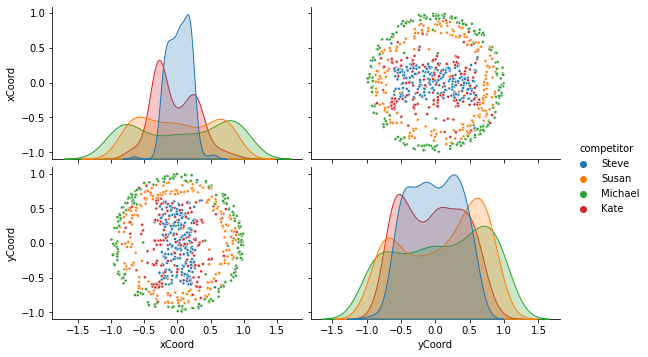

     xCoord    yCoord competitor
0  0.196451 -0.520341      Steve
1  0.476027 -0.306763      Susan
2  0.003175 -0.980736    Michael
3  0.294078  0.267566       Kate
4 -0.051120  0.598946      Steve


In [3]:
# data

dart_df = pd.read_csv('datasets/darts.csv')
dart_df
sns.pairplot( data= dart_df, hue= 'competitor', markers= '.', aspect= 1.6)
plt.show()
print(dart_df.head())

##### data prep

We can check that the labels, darts.competitor are not yet in a format to be understood by the neural network. They contain the names of the competitors as strings. We will first turn these competitors into unique numbers,then use the to_categorical() function from keras.utils to turn these numbers into their one-hot encoded representation.

This is useful for multi-class classification problems, since there are as many output neurons as classes and for every observation in our dataset we just want one of the neurons to be activated.

In [4]:
## data
dart_df = pd.read_csv('datasets/darts.csv')
# data prep
print('dart_df: \n', dart_df.head(),'\n\n' )

# train-test
train_dart_df = dart_df.sample( frac= 77./100 )
test_dart_df = dart_df.drop(train_dart_df.index)
# --------------------------- For TRAIN set ------------------------------------------

## transform person names into categorical var

# turn response variable into labeled codes
train_dart_df['competitor'] = pd.Categorical( train_dart_df['competitor'] )
train_dart_df['competitor'] = train_dart_df['competitor'].cat.codes

test_dart_df['competitor'] = pd.Categorical( test_dart_df['competitor'] )
test_dart_df['competitor'] = test_dart_df['competitor'].cat.codes

print('--------------------------------------------------------------------------')
print('\nLabel encoded competitors (for train set): \n',train_dart_df['competitor'].head())


# convert to one hot encoder
Y_train = keras.utils.to_categorical( train_dart_df['competitor'], dtype= 'float32' )
Y_test  = keras.utils.to_categorical( test_dart_df['competitor'],  dtype= 'float32' )
print('--------------------------------------------------------------------------')
print('\nOne-hot encoded competitors (Y train): \n',Y_train)


# X data
X_train = train_dart_df.drop( 'competitor', axis= 1 )
X_test = test_dart_df.drop( 'competitor', axis= 1 )

dart_df: 
      xCoord    yCoord competitor
0  0.196451 -0.520341      Steve
1  0.476027 -0.306763      Susan
2  0.003175 -0.980736    Michael
3  0.294078  0.267566       Kate
4 -0.051120  0.598946      Steve 


--------------------------------------------------------------------------

Label encoded competitors (for train set): 
 8      3
510    1
175    2
735    2
242    0
Name: competitor, dtype: int8
--------------------------------------------------------------------------

One-hot encoded competitors (Y train): 
 array([[0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.]], dtype=float32)


#### model architecture

In [5]:
tf.keras.backend.clear_session()

num_paras = X_train.shape[1]

kSeqModel_1 = keras.Sequential()
kSeqModel_1.add(  layer= Dense( 128, activation= 'relu', input_shape= (num_paras,) )  )
kSeqModel_1.add(  layer= Dense( 64, activation= 'relu' )  )
kSeqModel_1.add(  layer= Dense( 32, activation= 'relu' )  )
kSeqModel_1.add(  layer= Dense( 4, activation= 'softmax' ) )

# model compile
kSeqModel_1.compile( optimizer='adam', loss= 'categorical_crossentropy', metrics= ['accuracy'] )

kSeqModel_1.summary()

# model fit
kSeqModel_1.fit( x= X_train, y= Y_train,
                 epochs= 20, verbose= 2,
                 validation_split= 25./100
               )

# accuracy
model_Accuracy = kSeqModel_1.evaluate( x= X_test, y= Y_test )

print('\n\n',model_Accuracy)

# predict

yhat = kSeqModel_1.predict( x= X_test )

yhat_category =  np.argmax(yhat, axis= 1) 
ytest_category = np.argmax(Y_test, axis= 1)
print( yhat_category )
print( ytest_category )


device = cuda.get_current_device()
device.reset()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               384       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 132       
Total params: 10,852
Trainable params: 10,852
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
15/15 - 0s - loss: 1.3728 - accuracy: 0.2554 - val_loss: 1.3570 - val_accuracy: 0.2857
Epoch 2/20
15/15 - 0s - loss: 1.3390 - accuracy: 0.3160 - val_loss: 1.3234 - val_accuracy: 0.3052
Epoch 3/20
15/15 - 0s - loss: 1.2926 - accuracy: 0.363

<h3> 3. Multi-label Classification</h3>


Multi-label classification problems differ from multi-class problems in that each observation can be labeled with zero or more classes. So classes/labels are not mutually exclusive.

To account for this behavior what we do is have an output layer with as many neurons as classes but this time, unlike in multi-class problems, each output neuron has a <i><u>sigmoid activation</i></u> function. This makes each neuron in the output layer able to output a number between 0 and 1 independently.
<p>
Building a neural network to classify the farm parcels whether it requires irrigation based on various aprameters. Since, classes/labels are not mutually exclusive, we could water all, none or any combination of farm parcels based on the inputs parameters.


In [3]:
# data import n prep
irr_df = pd.read_csv( 'datasets/irrigation_machine.csv', delimiter=',');  irr_df.head()

# Train/Test dataset
train_df = irr_df.sample( frac= 80./100 )
test_df = irr_df.drop( train_df.index )

print('--------------------------------------------------------------------------')
print( '\nTrain dataset: \n', test_df.head() )

# X data
x_train = train_df.drop( train_df.columns[ [0,21,22,23] ], axis= 1 ).to_numpy( dtype= 'float16' ); x_train
x_test = test_df.drop( test_df.columns[ [0,21,22,23] ], axis= 1).to_numpy( dtype= 'float16' ); x_test
print('--------------------------------------------------------------------------')
print( '\nX dataset: \n', x_train, ' ', x_train.shape )

# Y data
y_train = train_df[ ['parcel_0','parcel_1','parcel_2'] ].to_numpy( dtype= 'int' ); y_train
y_test = test_df[ ['parcel_0','parcel_1','parcel_2'] ].to_numpy( dtype= 'int' ) ; y_test

print('--------------------------------------------------------------------------')
print( '\nY dataset: \n', y_train, ' ', y_train.shape )


--------------------------------------------------------------------------

Train dataset: 
     Unnamed: 0  sensor_0  sensor_1  sensor_2  sensor_3  sensor_4  sensor_5  \
15          15       0.0       3.0       1.0       4.0       3.0       0.0   
20          20       1.0       0.0       5.0       0.0       5.0       2.0   
21          21       1.0       1.0       5.0       1.0       8.0       1.0   
24          24       1.0       3.0       3.0       3.0       6.0       1.0   
25          25       0.0       1.0       0.0       1.0       1.0       2.0   

    sensor_6  sensor_7  sensor_8  ...  sensor_13  sensor_14  sensor_15  \
15       5.0       6.0       1.0  ...        7.0        7.0        2.0   
20       7.0       4.0       0.0  ...        1.0        3.0        2.0   
21       0.0       6.0       2.0  ...        5.0        2.0        2.0   
24       2.0       5.0       3.0  ...        3.0        3.0        1.0   
25       3.0       3.0       2.0  ...        2.0        2.0        2

In [4]:
# model architecture

keras.backend.clear_session()

kSeqModel_1 = keras.Sequential()
num_feature = x_train.shape[1]

kSeqModel_1.add(  layer= Dense( 128, activation= 'relu', input_shape= (num_feature,) )  )
kSeqModel_1.add(  layer= Dense( 128, activation= 'relu' )  )
kSeqModel_1.add(  layer= Dense( 32, activation= 'relu' )  )
kSeqModel_1.add(  layer= Dense( 3, activation= 'sigmoid' ) )

kSeqModel_1.compile( optimizer= 'adam',  loss= 'binary_crossentropy', metrics= ['accuracy'] )
kSeqModel_1.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               2688      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 32)                4128      
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 99        
Total params: 23,427
Trainable params: 23,427
Non-trainable params: 0
_________________________________________________________________


In [5]:
# fit model
kSeqModel_1.fit( x= x_train, y= y_train,
                 epochs= 100, validation_split= 20./100, verbose= 2)

Epoch 1/100
40/40 - 0s - loss: 0.4472 - accuracy: 0.5617 - val_loss: 0.3486 - val_accuracy: 0.5094
Epoch 2/100
40/40 - 0s - loss: 0.2862 - accuracy: 0.6195 - val_loss: 0.2712 - val_accuracy: 0.4938
Epoch 3/100
40/40 - 0s - loss: 0.2424 - accuracy: 0.6328 - val_loss: 0.2450 - val_accuracy: 0.5094
Epoch 4/100
40/40 - 0s - loss: 0.2214 - accuracy: 0.6352 - val_loss: 0.2557 - val_accuracy: 0.4469
Epoch 5/100
40/40 - 0s - loss: 0.2139 - accuracy: 0.6266 - val_loss: 0.2518 - val_accuracy: 0.5437
Epoch 6/100
40/40 - 0s - loss: 0.2007 - accuracy: 0.6328 - val_loss: 0.2325 - val_accuracy: 0.4875
Epoch 7/100
40/40 - 0s - loss: 0.1912 - accuracy: 0.6570 - val_loss: 0.2349 - val_accuracy: 0.7469
Epoch 8/100
40/40 - 0s - loss: 0.1970 - accuracy: 0.6477 - val_loss: 0.2400 - val_accuracy: 0.4125
Epoch 9/100
40/40 - 0s - loss: 0.1881 - accuracy: 0.6391 - val_loss: 0.2365 - val_accuracy: 0.5312
Epoch 10/100
40/40 - 0s - loss: 0.1723 - accuracy: 0.6523 - val_loss: 0.2459 - val_accuracy: 0.6094
Epoch 11/

Epoch 83/100
40/40 - 0s - loss: 6.5644e-04 - accuracy: 0.6367 - val_loss: 0.7252 - val_accuracy: 0.5969
Epoch 84/100
40/40 - 0s - loss: 5.9588e-04 - accuracy: 0.6344 - val_loss: 0.7234 - val_accuracy: 0.5906
Epoch 85/100
40/40 - 0s - loss: 5.6844e-04 - accuracy: 0.6367 - val_loss: 0.7414 - val_accuracy: 0.5938
Epoch 86/100
40/40 - 0s - loss: 5.7545e-04 - accuracy: 0.6313 - val_loss: 0.7304 - val_accuracy: 0.5906
Epoch 87/100
40/40 - 0s - loss: 5.2955e-04 - accuracy: 0.6328 - val_loss: 0.7412 - val_accuracy: 0.5875
Epoch 88/100
40/40 - 0s - loss: 5.2253e-04 - accuracy: 0.6359 - val_loss: 0.7397 - val_accuracy: 0.5844
Epoch 89/100
40/40 - 0s - loss: 4.9707e-04 - accuracy: 0.6359 - val_loss: 0.7457 - val_accuracy: 0.5906
Epoch 90/100
40/40 - 0s - loss: 4.9790e-04 - accuracy: 0.6328 - val_loss: 0.7541 - val_accuracy: 0.5906
Epoch 91/100
40/40 - 0s - loss: 4.4306e-04 - accuracy: 0.6352 - val_loss: 0.7571 - val_accuracy: 0.5969
Epoch 92/100
40/40 - 0s - loss: 4.2453e-04 - accuracy: 0.6328 - 

In [6]:
# prediction

yhat_float = kSeqModel_1.predict( x= x_test ); print(yhat_float)

yhat = np.round(yhat_float); print(yhat)

accuracy = kSeqModel_1.evaluate( x= x_test, y= y_test )[1]
print('Accuracy: ', accuracy)

array([[9.3588996e-01, 1.0000000e+00, 7.2608219e-10],
       [1.0000000e+00, 9.9035490e-01, 1.2093593e-03],
       [1.0000000e+00, 9.0940082e-01, 4.7652386e-12],
       ...,
       [9.9710208e-01, 9.8422335e-14, 4.9695668e-11],
       [2.4712263e-03, 9.9999785e-01, 4.1445019e-13],
       [9.9894673e-01, 9.9380952e-01, 9.9730170e-01]], dtype=float32)
array([[1., 1., 0.],
       [1., 1., 0.],
       [1., 1., 0.],
       ...,
       [1., 0., 0.],
       [0., 1., 0.],
       [1., 1., 1.]], dtype=float32)
13/13 [==============================] - 0s 1ms/step - loss: 1.0734 - accuracy: 0.6075
Accuracy:  0.6075000166893005


An output of the multi-label NN model could look like this: [0.76 , 0.99 , 0.66 ]. If we round up probabilities higher than 0.5, this observation will be classified as containing all 3 possible labels [1,1,1]. For this particular problem, this would mean watering all 3 farm parcels is the right thing to do, according to the network, given the input sensor measurements.

In [7]:

device = cuda.get_current_device()
device.reset()